Fishing harvest parameters for the Salish Sea Atlantis Model

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from shapely.geometry import Point
import ssam_groups as groups
from ssam_groups import cohorts

In [2]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scenario_paths = sorted([p for p in scenario_root.glob('highres_*_90/outputSalishSeaCATCH.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
for path in scenario_paths:
    print(path.parent.stem)

highres_2boxes_closed_90


In [3]:
def compare_scenario_catch(variable, box):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        catch = scenario.variables[variable+'_Catch'][:,box]
        time = scenario.variables['t']
        ax.plot(time, catch)
    ax.legend(names)
    ax.set_ylabel(variable + ' Catch (#)')
    #ax.set_title(pah, fontsize = 12);

In [4]:
def compare_cohort_catch(bio_group, scenario, name, boxes):
    label_size = 11
    font_size = 12
    line_width = 2

    time = scenario.variables['t']

    for species in bio_group:

        fig, ax = plt.subplots(figsize = (14,3))
        #ax.plot(event_start, 0, 'ok')

        numCohorts = cohorts[bio_group[species]]+1

        for cohort in range (1, numCohorts):

            new_species = bio_group[species] + str(cohort)
            catch_tb = scenario.variables[new_species + '_Catch'][:,boxes]
            catch = (catch_tb.sum(axis=1))
            ax.plot(time, catch, linewidth = line_width)
    
        ax.set_title(name, fontsize = font_size)
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel(str(bio_group[species]) + ' Catch (#)')
        ax.legend(['cohort 1','cohort 2','cohort 3','cohort 4','cohort 5','cohort 6','cohort 7','cohort 8','cohort 9','cohort 10',]) #loc='center left'

In [5]:
boundary_box = 0
haro_strait = 60
bellingham_bay = 55
crazy_box = 54

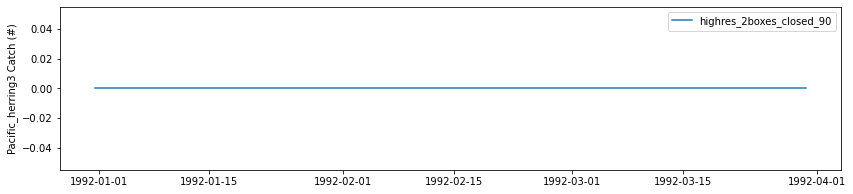

In [6]:
compare_scenario_catch('Pacific_herring3', haro_strait) #MPAPelagicFISH 0

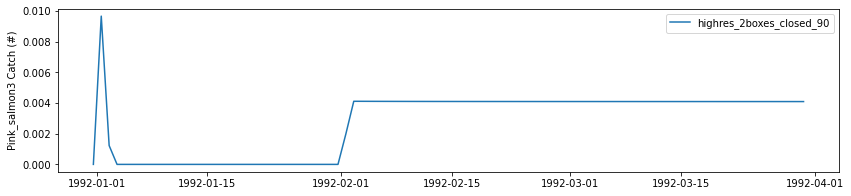

In [7]:
compare_scenario_catch('Pink_salmon3', haro_strait) #MPASalmon 1

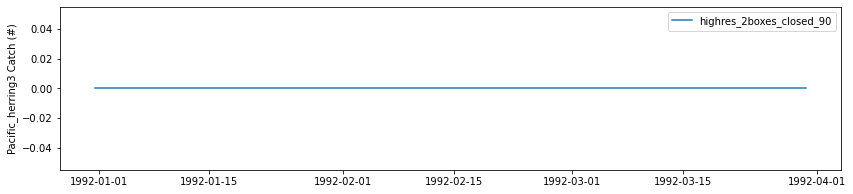

In [8]:
compare_scenario_catch('Pacific_herring3', bellingham_bay) #MPAPelagicFISH 0

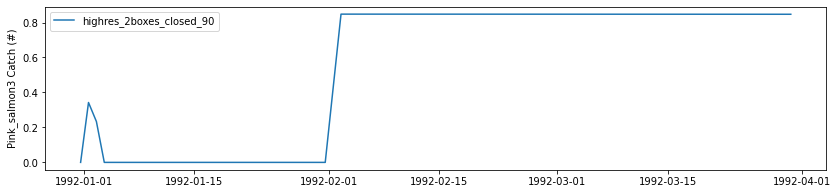

In [9]:
compare_scenario_catch('Pink_salmon3', bellingham_bay) #MPASalmon 1

To test the MPAYYY parameters, MPASalmon was set to 1, and MPAPelagicFISH was set to 0. No fishing occured for pelagic fish, and fishing occured for salmon, except during the 30-day closed-to-fishing period in Bellingham Bay and Haro Strait. 

MPAYYY parameter needs to be set to 1 for the box to respond to ClosedContam code. 1 means 100% of the box is OPEN TO BE FISHED, and then 100% of the box will be closed to fishing when the box is closed. 0 indicated that 0% of the box is OPEN TO BE FISHED, which basically signals the box is closed to fishing for the entire run, and will not respond to opening or closure due to contaminants. 

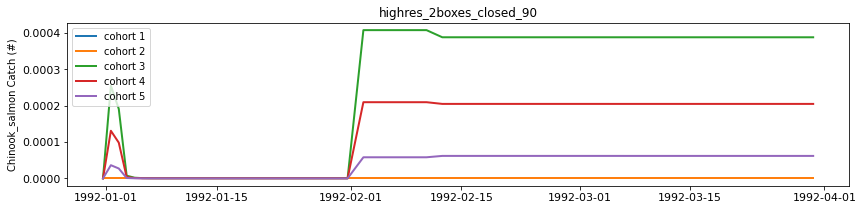

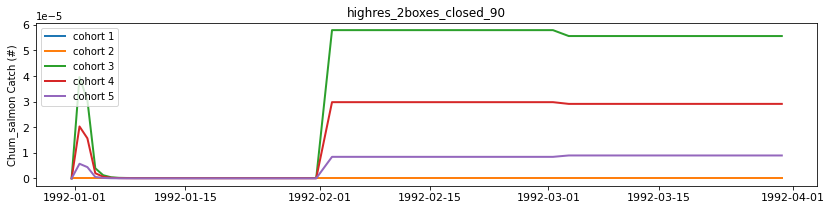

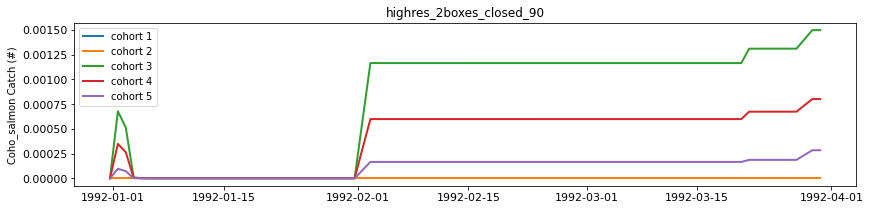

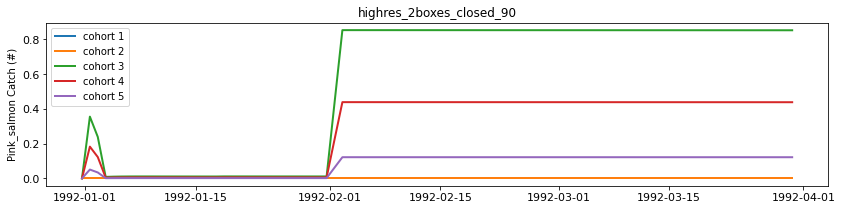

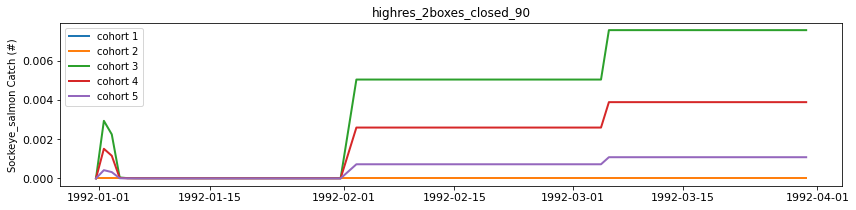

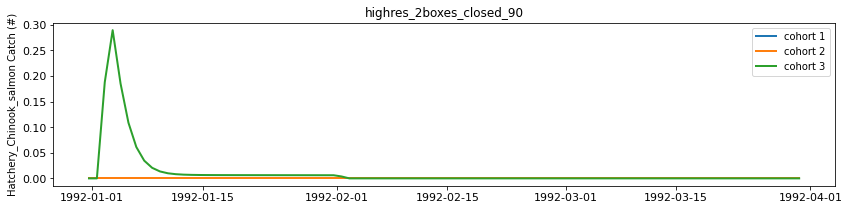

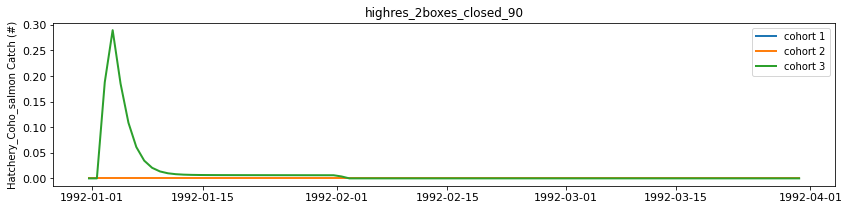

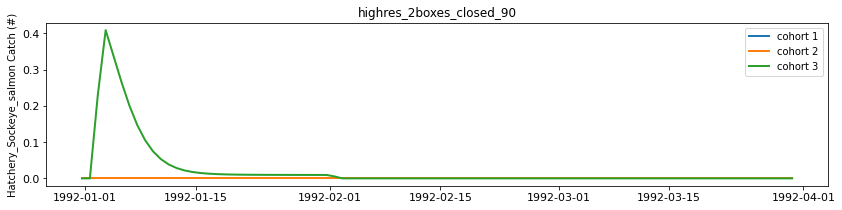

In [10]:
bellingham_boundary = [54,55]
for scenario, path in zip(scenario_datasets, scenario_paths):
    compare_cohort_catch(groups.salmon, scenario, path.parent.stem, bellingham_boundary)

In [11]:
# Salish Sea Atlantis Shapefile
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
ssam_boundary_boxes = data_df['BOUNDARY']==1
ssam_boundaries = data_df.index[ssam_boundary_boxes]

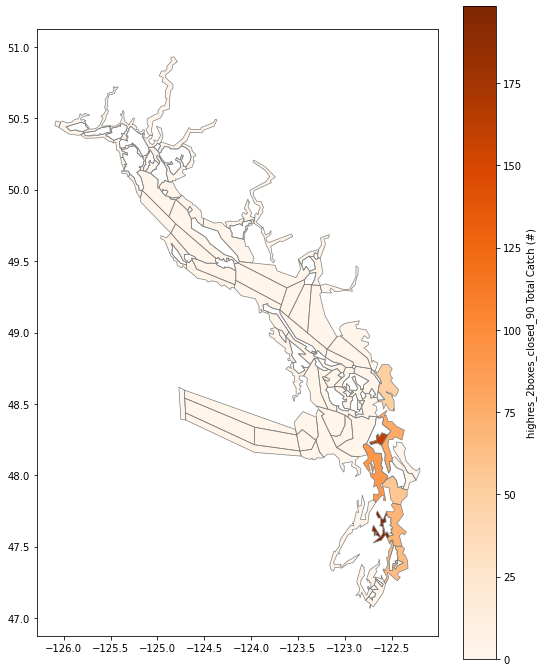

In [12]:
for scenario, path in zip(scenario_datasets, scenario_paths):
    catch = scenario.variables['Pink_salmon3_Catch']
    sum_catch_per_box = catch.sum(axis=0)
    _cmap = cm.Oranges
    land_df = data_df.loc[land_boxes]
    boundaries_df = data_df.loc[ssam_boundaries]
        
    data_df['sum_catch'] = sum_catch_per_box
    data_df.loc[land_boxes, 'sum_catch'] = 0
    data_df.loc[ssam_boundaries, 'sum_catch'] = 0
        
    ax = data_df.plot(figsize=(9, 12), column = 'sum_catch', cmap=_cmap,
        legend=True, legend_kwds={'label': str(path.parent.stem)+" Total Catch (#)"
            },)
    land_df.plot(ax=ax, color='white')
    #boundaries_df.plot(ax=ax, color='white')
    data_df.boundary.plot(ax=ax, color="grey", linewidths=0.7)

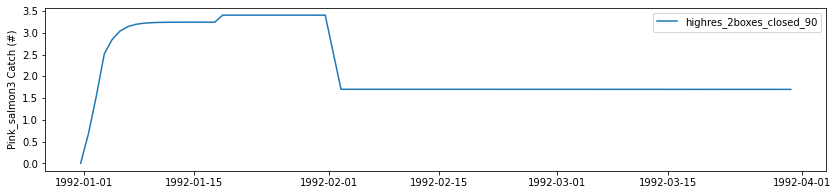

In [14]:
#Testing that fishing continues in other boxes
compare_scenario_catch('Pink_salmon3', 23) #MPASalmon 1

Box 23 is the most abundant box for Pink Salmon on the above map. It was not selected to close during the run, and correctly shows that fishing for Pink Salmon remained open for the 90-day duration of the run.